
`
Predicting Corporate Failure : Logit Regression

Modified from Ohlson, J.A., 1980. "Financial ratios and the probabilistic prediction of bankruptcy." *Journal of accounting research*, pp.109-131.

In [1]:
# Connecting the Python Code with the google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Import necessary libraries

import numpy as np
import pandas as pd
in_dir = "/content/drive/MyDrive/MSBA_Data/"

The Bankruptcy data are collected only for firms with Assets > $100 m (adjusted for inflation relative to 1980 )   

In [3]:
bankruptcy_data = pd.read_excel(in_dir + "failure_Florida_short.xlsx")           # Bankruptcy Data
bankruptcy_data['Date'] = pd.to_datetime(bankruptcy_data.Date10kBefore)
len(bankruptcy_data)

1218

In [4]:
#adjust CPI relative to 1980 CPI (Why?)
inflation_data = pd.read_csv(in_dir + "CPI.csv")                                  # CPI data
inflation_data['Date'] = pd.to_datetime(inflation_data['DATE'])
inflation_data['seq'] = 12 * inflation_data['Date'].dt.year + inflation_data['Date'].dt.month
cpi_1980 = inflation_data.loc[inflation_data.Date == '1980-01-01', 'CPIAUCSL'].values
inflation_data['CPI'] = inflation_data['CPIAUCSL']/cpi_1980                               #Inflation factor CPI as of 1980-01 = 1
inflation = inflation_data[['CPI', 'seq']].copy()
                               #Keep only the necessary columns

In [5]:
cpi_1980

array([78.])

In [6]:
inflation_data[['Date', 'CPI']]

,Date,CPI
0,1947-01-01,0.275385
1,1947-02-01,0.277179
2,1947-03-01,0.282051
3,1947-04-01,0.282051
4,1947-05-01,0.281410
...,...,...
917,2023-06-01,3.895397
918,2023-07-01,3.901897
919,2023-08-01,3.926526
920,2023-09-01,3.942064


Process Compustat data.
Compustat variables to compute features
*   at: Total Assets
*   csho: Shares Outstanding
*   prcc_f: Fiscal year-end price







In [7]:
Cstat_data = pd.read_csv( in_dir + "Cstat_data.csv")
Cstat_data = Cstat_data[Cstat_data.indfmt == 'INDL'].copy()                       # filters out firms with 10K data coded not coded as indfmt = 'INDL'  eg. indfmt = 'FS' or financials
Cstat_data['Date'] = pd.to_datetime(Cstat_data.datadate)
Cstat_data['seq'] = 12 * Cstat_data['Date'].dt.year + Cstat_data['Date'].dt.month
Cstat_data = Cstat_data.merge(inflation, how = 'left', on  = [ 'seq'])          #merge with inflation data to compute asset values in 1980 dollars
Cstat_data['at_plus'] = np.where(Cstat_data['at'] > 0 , Cstat_data['at'], np.nan) # set negative values to np.nan before converting to logs later
Cstat_data['inf_adj_at'] = Cstat_data['at_plus']/Cstat_data.CPI                   #Express asset values in 1980 dollars (why)
Cstat_data['market_cap'] = Cstat_data.csho * Cstat_data.prcc_f                    #Market capitalization as of fiscal year end
Cstat_data['market_cap'] = Cstat_data['market_cap'].apply(lambda x: 0.5 if x < 0.5 else x) #setting market cap to a min value of .5 - otherwise b2m becomes too large


Compustat variables to compute features


*   lct: total current liabilities

*   act: total current assets
*   dltt: total long term liabilities
*   ni: net income
*   oancf: cash flow from operations


---


**Features**
*  log_asset_size : Logarithm of total assets in 1980 dollars
*   TLTA : Total liabilities/Total Assets
*   WCTA : Working capital (=act - lct)/Total Assets
*   CLCA : Current liabilities/Current assets
*   OENEG: Dummy variable = 1 if total liabilities > total assets, 0 otherwise
*   NITA : Net income/total assets
*   FUTL : Cash flow from operations / Total liabilities
*   INTWO: Dummy variable = 1 if ni < 0 for the last two years,  0 otherwise
*   CHIN : Change in ni/(|ni| + |last year ni|
*   b2m  : Book value of equity/ market cap of equity
*







In [ ]:
Cstat_data['log_asset_size'] =  np.log(Cstat_data['inf_adj_at'])
Cstat_data['Total_liabilities'] = Cstat_data['lct'] + Cstat_data['dltt']
Cstat_data['TLTA'] =  Cstat_data['Total_liabilities'] / Cstat_data['at_plus']
Cstat_data['WCTA'] =  (Cstat_data['act']  - Cstat_data['lct']) / Cstat_data['at_plus']
Cstat_data['CLCA'] = np.where(Cstat_data['act'] > 0.0011 , (Cstat_data['lct'] + Cstat_data['dltt'])/ Cstat_data['act'], np.nan)
Cstat_data['OENEG'] = np.where((Cstat_data['lct'] + Cstat_data['dltt']) >  Cstat_data['at'] , 1, 0)
Cstat_data['NITA'] =  Cstat_data['ni']/ Cstat_data['at_plus']
Cstat_data['FUTL'] = np.where(Cstat_data['Total_liabilities'] > 0.001 , Cstat_data['oancf']/ Cstat_data['Total_liabilities'], np.nan)
Cstat_data['lag_ni'] = Cstat_data.groupby('gvkey')['ni'].shift()

Cstat_data['INTWO'] = np.where((Cstat_data['ni'] < 0) & (Cstat_data['lag_ni'] < 0), 1, 0)
Cstat_data['CHIN'] = (Cstat_data['ni'] - Cstat_data['lag_ni']) / (np.abs(Cstat_data['ni']) + np.abs(Cstat_data['lag_ni']))

Cstat_data['b2m'] = (Cstat_data['at'] - Cstat_data['Total_liabilities']) / Cstat_data['market_cap'] #bool value of equity = (Cstat_data['at'] - Cstat_data['Total_liabilities'])

In [ ]:
len(Cstat_data)

480148

Merge with Bankruptcy data

In [ ]:
cstat_bankruptcy = Cstat_data.merge(bankruptcy_data, how = 'left', left_on =  ['Date', 'gvkey'], right_on = ['Date', 'GvkeyBefore'])
Y = cstat_bankruptcy.loc[cstat_bankruptcy.inf_adj_at > 100].copy()
#Y = cstat_bankruptcy.copy()                                                     #Y is a Dataframe that contains dates, and features
Y['year'] = Y.Date.dt.year
Y['Outcome'] = np.where(Y.Chapter.isna(), 0, 1)                                # 1 = bankrupt, if Y.Chapter notna then the firm did not file for bankruptcy in the year after the 10K date
#Y.set_index('year', inplace = True)
features = ['year', 'log_asset_size', 'TLTA', 'WCTA', 'CLCA', 'OENEG', 'NITA',
       'FUTL',  'INTWO', 'CHIN', 'b2m']
len(Y)

178388

Compare features across categories

In [ ]:
Features_by_category = Y.groupby('Outcome')[features].mean()
Features_by_category

,year,log_asset_size,TLTA,WCTA,CLCA,OENEG,NITA,FUTL,INTWO,CHIN,b2m
Outcome,,,,,,,,,,,
0,2002.338384,6.664372,0.489101,0.153091,2.614302,0.017663,0.023424,0.402438,0.103164,0.022456,5.108843
1,2002.891473,6.136113,0.894087,-0.173637,4.641428,0.228128,-0.206552,-0.009777,0.591362,-0.353314,-2.558213


Examine the data

In [ ]:
Y[features].groupby('year').count()

,log_asset_size,TLTA,WCTA,CLCA,OENEG,NITA,FUTL,INTWO,CHIN,b2m
year,,,,,,,,,,
1977,1676,1440,1388,1388,1676,1675,0,1676,0,1078
1978,2395,2089,1998,1998,2395,2390,0,2395,1642,1645
1979,2355,2038,1955,1954,2355,2353,0,2355,2312,1622
1980,2342,2012,1937,1935,2342,2340,0,2342,2308,1589
1981,2329,1990,1920,1918,2329,2323,0,2329,2287,1580
1982,2393,2007,1932,1928,2393,2390,0,2393,2268,1689
1983,2468,2067,1979,1976,2468,2458,0,2468,2364,1745
1984,2521,2089,2002,1998,2521,2518,0,2521,2431,1762
1985,2575,2104,2025,2020,2575,2567,0,2575,2442,1745


In [ ]:
Y.dropna(subset = features, inplace = True)
Y = Y[(Y.year > 1987) & (Y.year < 2022) ]
len(Y)


86624

In [ ]:
q = Y[features].quantile(q = [ 0,.01, .05, .95, .99, 1])             #Are there outliers among features?
q.T

,0.00,0.01,0.05,0.95,0.99,1.00
year,1988.000000,1988.000000,1990.000000,2020.000000,2021.000000,2021.000000
log_asset_size,4.605176,4.634427,4.751330,9.385347,10.602440,12.091605
TLTA,0.000029,0.050374,0.132330,0.845154,1.194810,7.404401
WCTA,-4.756474,-0.263188,-0.082831,0.545451,0.748302,0.999161
CLCA,0.000839,0.108512,0.262248,7.463105,15.844201,508.336788
OENEG,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
NITA,-22.037544,-0.468802,-0.163487,0.154939,0.266864,21.789094
FUTL,-997.085603,-0.861723,-0.099739,0.931407,2.011059,4630.000000
INTWO,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
CHIN,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000


Winsorize extreme values and create test and training data. Train with pre-2006 data and test with post-2006 data

In [ ]:
X = Y[features]
y = Y['Outcome']
from scipy.stats import mstats                                                   #mstats is useful for winsorization
def winsorize_series(group):
    return mstats.winsorize(group, limits=[.05, .05])
features_win = ['year', 'log_asset_size',  'TLTA', 'WCTA', 'CLCA',  'NITA',     #features_win are the features to be wonsorized
                'FUTL',   'CHIN', 'b2m']                                         #DO NOT WINSORIZE DUMMY (OENEG ) AND NORMALIZED VARAIBLE (INTWO)
#Training data
X_pre2006 = Y[features_win][Y.year<2006].groupby('year')                         #Grouped by 'year' becuase financial ratio distributions vary across years
X_train = X_pre2006.transform(winsorize_series)
X_train[['OENEG', 'INTWO']]  = Y[['OENEG', 'INTWO']]                            #features that are not winsorized (OENEG and INTWO)
y_train = Y['Outcome'].loc[Y.year<2006]

#Test data
X_post2006 = Y[features_win][Y.year>=2006].groupby('year')
X_test = X_post2006.transform(winsorize_series)
X_test[['OENEG', 'INTWO']]  = Y[['OENEG', 'INTWO']]
y_test = Y['Outcome'].loc[Y.year >= 2006]

Use SK learn to fit logistic regression.

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty = 'none', max_iter=200, random_state=16)    # 'penalty' allows you to run penalized regressions, usful when there are a large number of parameters to be estimated.
# fit the model with training data
logreg.fit(X_train, y_train)
logreg.coef_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


array([[-0.17835098,  4.63789048, -3.98211354, -0.07995864, -3.49659556,
        -6.43654922, -0.52486085,  0.54086803,  1.05891692,  0.41886066]])

Use statsmodel for statistical significance.

In [ ]:
#%% SM routine
import statsmodels.api as sm
logit_model=sm.Logit(y_train,sm.add_constant(X_train))                         #add constant with sm.add_constant
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.030399
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                40910
Model:                          Logit   Df Residuals:                    40899
Method:                           MLE   Df Model:                           10
Date:                Thu, 01 Feb 2024   Pseudo R-squ.:                  0.3353
Time:                        23:03:33   Log-Likelihood:                -1243.6
converged:                       True   LL-Null:                       -1871.0
Covariance Type:            nonrobust   LLR p-value:                2.203e-263
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -6.5548      0.495    -13.235      0.000      -7.526      -5.584
log_asset_size  

Fit analysis

In [ ]:
#%%
y_pred = logreg.predict(X_test)
probs = logreg.predict_proba(X_test)                                            #Output (***). The first column represents the probability of belonging to the negative class (class 0), and the second column is the probability of the sample belonging to the positive class (class 1).
                                                                                # We will use this when we consider different thresholds later
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[45441,    23],
       [  246,     4]])

Confusion matrix

Text(0.5, 427.9555555555555, 'Predicted label')

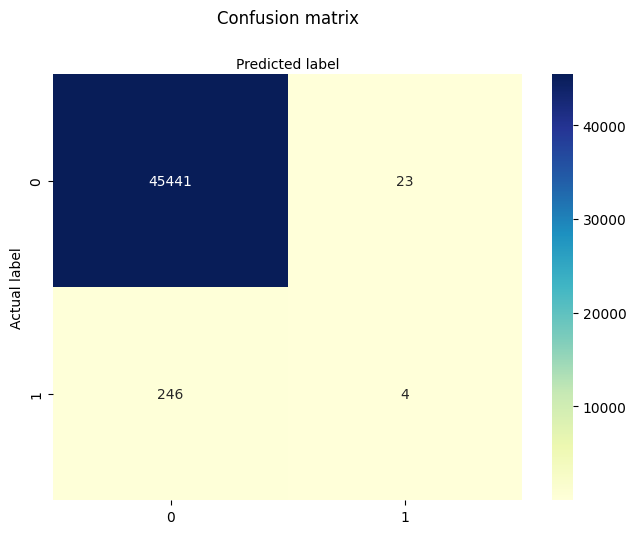

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



ROC

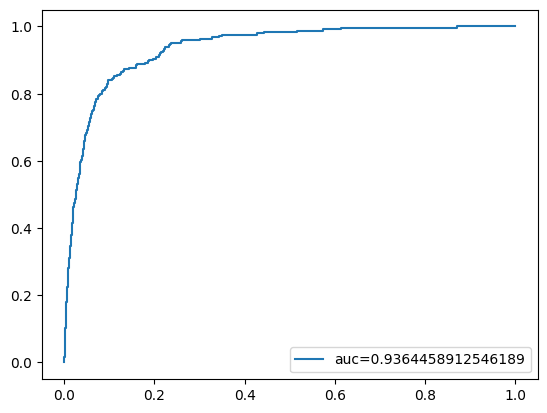

In [ ]:
#%% Receiver Operating Characteristic (ROC) curve
y_pred_proba = logreg.predict_proba(X_test)[::,1]                                #Probability of default for the test sample
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc=" + str(auc))                                 #plot false positive rate vs true positive rate for different  thresholds for classification

plt.legend(loc=4)
plt.show()

What is the appropriate probability threshold to be classified as positive outcome (for category = 1)?

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracy = accuracy_score(y_test, y_pred)                                       # Accuracy = (True Positive + True Negative)/Total
precision = precision_score(y_test, y_pred)                                     # precision = True Positive / (True Positive + False Positive)
recall = recall_score(y_test, y_pred)                                           # recall = True Positive / (True Positive + False Negative)


Examine the accuracy, recall and precition for different thresholds  

In [ ]:
y_prediction = pd.DataFrame(probs[::,1], index = y_test.index, columns = ['Predicted_probs'])                    #uses the dataframe "probs" previously computed in the step (***)
                                                                                                                 # 'probs[::,1]', is the columns containing probability (y|features) = 1 for all observations in the test dataset
Precision_recall = pd.DataFrame(index = range(1, 10),  columns= ["threshold","accuracy", "recall", "precision"])
for i in range (1,20):
        prob_threshold = i/100
        prediction = np.where(y_prediction > prob_threshold, 1, 0)
        Precision_recall.at[i,'threshold'] = prob_threshold
        Precision_recall.at[i,'accuracy'] = accuracy_score(y_test, prediction)
        Precision_recall.at[i,'recall'] = recall_score(y_test, prediction)
        Precision_recall.at[i,'precision'] = precision_score(y_test, prediction)
Precision_recall

,threshold,accuracy,recall,precision
1,0.01,0.891806,0.844,0.041227
2,0.02,0.937809,0.744,0.062732
3,0.03,0.955506,0.636,0.075642
4,0.04,0.964737,0.556,0.084756
5,0.05,0.971584,0.496,0.095605
6,0.06,0.9762,0.464,0.108411
7,0.07,0.979372,0.404,0.112849
8,0.08,0.981625,0.364,0.117876
9,0.09,0.983397,0.332,0.122963
10,0.1,0.984862,0.312,0.130435
